# Просепт (машинное обучение)

<font size = 4> **Описание проекта**

Заказчик производит несколько сотен различных товаров бытовой и промышленной химии, а затем продаёт эти товары через дилеров. Дилеры, в свою очередь, занимаются розничной продажей товаров в крупных сетях магазинов и на онлайн площадках.    
Для оценки ситуации,  управления ценами и  бизнесом в целом, заказчик периодически собирает информацию о том, как дилеры продают их товар. Для этого они парсят сайты дилеров, а затем сопоставляют товары и цены.    
Зачастую описание товаров на сайтах дилеров отличаются от того описания, что даёт заказчик. Например, могут добавляться новый слова ("универсальный", "эффективный"), объём (0.6 л --- 600 мл). Поэтому сопоставление товаров дилеров с товарами производителя делается вручную.

<font size = 4> **Цель проекта**

Разработка решения, которое отчасти автоматизирует процесс сопоставления товаров. Основная идея - предлагать несколько товаров заказчика, которые с наибольшей вероятностью соответствуют размечаемому товару дилера. 
Предлагается реализовать это решение, как онлайн сервис, открываемый в веб-браузере. 

**Выбор наиболее вероятных подсказок делается методами машинного обучения.**
    

<font size = 4> **План проекта** </font>    

**1.  Изучение данных.**     

1.1  Установка библиотек.    
1.2  Импорт библиотек и методов работы с данными.     
1.3  Считывание данных из файлов.     
  

**2.  Анализ данных.**     

2.1  Анилиз длин текстов.     
2.2  Частотный анализ текстов.       


**3.  Предобработка данных и ранжирование объектов.**     

3.1  Фильтр необходимых признаков.    
3.2  Обработка текстов.    
3.3  Написание функций.     
3.4  Исследование метода мешка слов.     
3.5  Исследование метода TF-IDf.    
3.5  Использование эмбедингов.     


**4.  Вывод.**     
   

**5.  Продолжение работы (исследование, эксперименты).**      

## Изучение данных

### Установим библиотеки.

### Выполним импорт нужных библиотек и методов работы с данными.

In [1]:
# Импорт стандартных библиотек
import warnings
import re

# Из библиотеки collections импорт счётчика "Counter" для подсчёта слов в списке
# from collections import Counter

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch

# Отключение предупреждений
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Импорт моделей машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer

# Импорт предобученного токенайзера и модели для получения эмбедингов
from transformers import BertModel, BertTokenizer
from transformers import (AutoTokenizer,
                          AutoModel)
from sentence_transformers import SentenceTransformer

# Импорт метрик
from sklearn.metrics import (roc_auc_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             precision_recall_curve,
                             roc_curve,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

# Импорт способов работы с выборками и функций кросс-валидации
from sklearn.model_selection import (train_test_split,
                                     cross_val_predict)

# Импорт индикатора выполнения
from tqdm import notebook

# Импорт токенайзера и стоп - слов из nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Импорт библиотеки для создания визуализации частотности слов 
from wordcloud import WordCloud

# Импорт способа использования синтаксиса Markdown при вводе текста в ячейке
from IPython.display import Markdown

# Задание константы (Ответ на главный вопрос жизни, вселенной и всего такого)
RANDOM_STATE = 42

### Считываем данные из CSV-файла в датафрейм и сохраняем в переменную.

#### Рассмотрим файл `marketing_dealer.csv`.

In [3]:
dealer = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_dealer.csv', sep=';')
dealer

,id,name
0,1,Moi_vibor_WB
1,2,Akson
2,3,Bafus
3,5,Castorama
4,6,Cubatora
5,7,Komus
6,9,Megastroy
7,10,OnlineTrade
8,11,Petrovich
9,12,sdvor


#### Рассмотрим файл `marketing_product.csv`.

In [4]:
base = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_product.csv', sep=';', index_col=[0])
base

,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
0,245,008-1,4.680008e+12,Антисептик невымываемыйPROSEPT ULTRAконцентрат...,360.00,858.0,20.0,Антисептик невымываемый для ответственных конс...,Антисептик невымываемый для ответственных конс...,Антисептик невымываемый для ответственных конс...,189522705.0,150033482.0,008-1,NaN
1,3,242-12,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,460.16,1075.0,NaN,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,NaN,NaN,NaN,NaN,NaN
2,443,0024-06 с,4.680008e+12,"Герметик акриловый цвет сосна, ф/п 600мл",307.00,644.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет сосна, ф/п 600мл",Герметик акриловый для швов для деревянных дом...,189522735.0,150126217.0,0024-06-с,NaN
3,147,305-2,4.610093e+12,Кондиционер для белья с ароматом королевского...,157.73,342.0,29.0,"Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...",339377922.0,150032962.0,305-2,NaN
4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,127,152-5,4.680008e+12,Средство для уборки помещений после пожара с д...,849.78,1985.0,40.0,Средство для уборки помещений после пожара с д...,Средство для уборки помещений после пожара с д...,Средство для уборки помещений после пожара с д...,451969758.0,149705851.0,152-5,NaN
492,160,289-1,4.680008e+12,"Жидкое моющее средство для стирки шерсти, шелк...",201.00,436.0,23.0,"Гель для стирки шерсти, шелка и деликатных тка...","Гель для стирки шерсти, шелка и деликатных тка...","Гель для стирки шерсти, шелка и деликатных тка...",446058619.0,150032628.0,289-1,289-10
493,74,192-05,4.680008e+12,Средство для чистки гриля и духовых шкафовCook...,108.60,254.0,49.0,Cредство для чистки гриля и духовок Cooky Gril...,Cредство для чистки гриля и духовок Cooky Gril...,Cредство для чистки гриля и духовок Cooky Gril...,449311005.0,154533100.0,192-05,192-050
494,34,186-5,4.680008e+12,Средство для мытья полов с полимерным покрытие...,579.74,1354.0,40.0,Профессиональное средство для мытья полов с по...,Профессиональное средство для мытья полов с по...,Профессиональное средство для мытья полов с по...,451107584.0,149705852.0,186-5,NaN


In [5]:
# Пропуски в base['name']
base[(base['name'].isna()) | (base['id'] == 436)]

,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
23,503,0024-7 о,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150126213.0,NaN,NaN
35,504,w022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,436,Р1 09005,4.680008e+12,,500.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Пропуски в base['name_1с']
base[base['name_1c'].isna()]

,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN
23,503,0024-7 о,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150126213.0,NaN,NaN
31,118,273-20,NaN,Средство усиленного действия для чистки коптил...,3730.0,8712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,119,274-20,NaN,Средство низкопенное для очистки алюминия и...,2818.0,6581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,504,w022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,182,P1 11005,NaN,Cредство для рук гигиеническое с антибактериал...,565.0,1319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,181,P1 11800,NaN,Cредство для рук гигиеническое с антибактериал...,155.0,361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,186,P1 06005,NaN,Жидкое мыло с антибактериальным компонентом дл...,492.0,1067.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,436,Р1 09005,4.680008e+12,,500.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,433,D1 01050-3,NaN,"Кожный антисептик PROF DZ готовый состав / 0,1 л",112.8,226.0,NaN,NaN,NaN,NaN,NaN,150119529.0,NaN,NaN


**Замечание:**  
Признаком для сравнения текстов выберем `name_1c` по просьбе заказчика.

In [7]:
# Удаляем строки с пропусками в столбце "name_1c"
base = base[base['name_1c'].notna()]

**Замечание:**  
Можно, также, попробовать заменить пропущенные значения в `name_1c` имена товаров из столбца `name`.

#### Рассмотрим файл `marketing_dealer.csv`.

In [8]:
parsing = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_dealerprice.csv', sep=';')
parsing

,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_pros...,Средство универсальное Prosept Universal Spray...,2023-07-11,2
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multip...,"Концентрат Prosept Multipower для мытья полов,...",2023-07-11,2
2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyus...,Средство для чистки люстр Prosept Universal An...,2023-07-11,2
3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosep...,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...",2023-07-11,2
4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_b...,Средство моющее для бани и сауны Prosept Multi...,2023-07-11,2
...,...,...,...,...,...,...,...
20411,20566,534517451,823.0,https://www.ozon.ru/product/534517451,"Огнебиозащита для древесины PROSEPT 2 группа, ...",2023-07-31,18
20412,20567,530308963,418.0,https://www.ozon.ru/product/530308963,"Антисептик многофункциональный ФБС, ГОСТ 5 л",2023-07-31,18
20413,20568,531730388,2986.0,https://www.ozon.ru/product/531730388,"Средство для удаления ржавчины PROSEPT, 1 шт",2023-07-31,18
20414,20569,1090913025,579.0,https://www.ozon.ru/product/1090913025,Герметик акриловый межшовный для деревянных ко...,2023-07-31,18


In [9]:
# Вывод количества пропусков на экран
parsing.isna().sum()

id                0
product_key       0
price             0
product_url     234
product_name      0
date              0
dealer_id         0
dtype: int64

In [10]:
# Получение информации о диллере с пропущенными url
parsing[parsing['product_url'].isna()]['dealer_id'].unique()

array([7], dtype=int64)

**Замечание:**  
Для диллера № 7 `Komus` данные по `url` отсутствуют.

In [11]:
# Подсчёт дубликатов
parsing['product_name'].duplicated().sum()

18463

In [12]:
# Количество уникальных значений
len(parsing['product_name'].unique())

1953

**Замечание:**  
В этой таблице очень много дубликатов. Для обучения и тестирования модели они нам не понадобятся. В имеющихся данных всего 1953 уникальных названий.

In [13]:
# Удаление дубликатов
parsing_clear = parsing[~parsing['product_name'].duplicated()]
parsing_clear

,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_pros...,Средство универсальное Prosept Universal Spray...,2023-07-11,2
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multip...,"Концентрат Prosept Multipower для мытья полов,...",2023-07-11,2
2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyus...,Средство для чистки люстр Prosept Universal An...,2023-07-11,2
3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosep...,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...",2023-07-11,2
4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_b...,Средство моющее для бани и сауны Prosept Multi...,2023-07-11,2
...,...,...,...,...,...,...,...
20159,20311,856988,2472.0,https://akson.ru//p/kraska_grunt_fasadnaya_pro...,Краска-грунт фасадная PROSEPT Proff 3 в 1 для ...,2023-07-31,2
20162,20314,856956,445.0,https://akson.ru//p/kraska_grunt_fasadnaya_pro...,Краска-грунт фасадная PROSEPT OSB Proff 3 в 1 ...,2023-07-31,2
20168,20320,651260,484.0,https://akson.ru//p/sredstvo_dlya_udaleniya_kl...,"Средство для удаления клейкой ленты, клея, нак...",2023-07-31,2
20284,20439,900996549,294.0,https://www.ozon.ru/product/900996549,Отбеливатель для древесины PROSEPT ECO 50 гото...,2023-07-31,18


**Замечание:**  
Остальсь 1953 строки.

#### Рассмотрим файл `marketing_productdealerkey.csv`.

In [14]:
match = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_productdealerkey.csv', sep=';')
match

,id,key,dealer_id,product_id
0,1,546227,2,12
1,2,651265,2,106
2,3,546257,2,200
3,4,546408,2,38
4,5,651258,2,403
...,...,...,...,...
1695,2019,530017190,18,267
1696,2020,530139882,18,286
1697,2021,534659036,18,129
1698,2022,898350801,18,1


In [15]:
# Количество уникальных значений полученных с помощью парсинга
len(match['key'].unique())

1700

In [16]:
# Количество уникальных значений из базы
len(match['product_id'].unique())

438

**Замечание:**  
Мы можем сопоставить не все имеющиеся данные. Проверочная таблица имеет информацию по 1700 уникальным названиям из данных парсинга и 438 из базы заказчика.

Для проверки работы модели предсказаний объединим данные из двух таблиц и оставим только те строки в которых присутствует необходимая нам информация.

## Анализ данных.

### Посмотрим на длины текстов.

In [17]:
# Регулярное выражение содержащее буквы на русском и английском языках и цифры
pattern = r'\w*[a-zA-Zа-яА-ЯёЁ0-9]+\w*'

In [18]:
# Преобразуем колонку с коментариями в список списков со словами из комментариев
name_list_base = []
for string in base['name_1c']: 
    name_list_base.append(re.findall(pattern, str(string)))
# Создадим список из длин комментариев
length_name_base = []
for comment in name_list_base:
    length_name_base.append(len(comment))

In [19]:
# Преобразуем колонку с коментариями в список списков со словами из комментариев
name_list_pars = []
for string in parsing_clear['product_name']: 
    name_list_pars.append(re.findall(pattern, str(string)))
# Создадим список из длин комментариев
length_name_pars = []
for comment in name_list_pars:
    length_name_pars.append(len(comment))

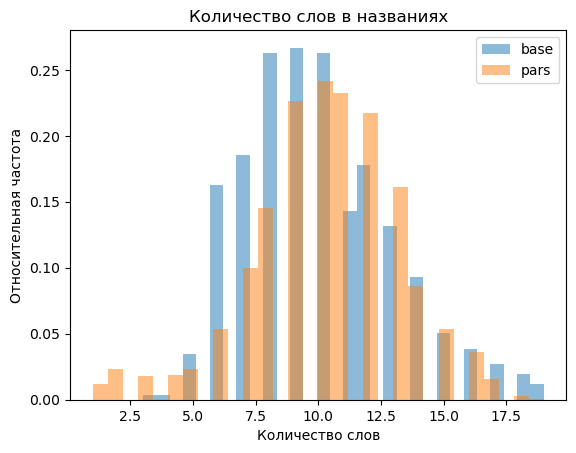

Минимальная и максимальная длины названия в base: 3 , 19
Минимальная и максимальная длины названия в pars: 1 , 19


In [20]:
# Построим гистограмму распределения комментариев по длинам
plt.hist(length_name_base, bins=30, alpha=0.5, density=True, label='base')
plt.hist(length_name_pars, bins=30, alpha=0.5, density=True, label='pars')
plt.legend(loc='upper right')
plt.xlabel('Количество слов');
plt.ylabel('Относительная частота');
plt.title('Количество слов в названиях');
plt.show()
print('Минимальная и максимальная длины названия в base:', min(length_name_base), ',', max(length_name_base))
print('Минимальная и максимальная длины названия в pars:', min(length_name_pars), ',', max(length_name_pars))

**Замечание:**  Длины названий не сильно отличаются в двух таблицах. Распределения похожи. 

In [21]:
# Вывод строк с короткими названиями из base
base['length'] = length_name_base
display(base[base['length'] < 5])

,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td,length
8,505,СФ001-5,4.610093e+12,Антисептик универсальный суперсильный,200.0,510.0,20.0,Антисептик универсальный суперсильный,Антисептик универсальный суперсильный,Антисептик универсальный суперсильный,NaN,NaN,NaN,NaN,3
297,162,С1 03500,4.680008e+12,Универсальный пятновыводительCandyготовый сост...,159.0,371.0,39.0,Профессиональный пятновыводитель PROSEPT Candy,Профессиональный пятновыводитель PROSEPT Candy,Профессиональный пятновыводитель PROSEPT Candy,449818261.0,150031995.0,С1-03500,NaN,4


In [22]:
# Вывод строк с короткими названиями из pars
parsing_clear['length'] = length_name_pars
display(parsing_clear[parsing_clear['length'] < 3].sample(5))

,id,product_key,price,product_url,product_name,date,dealer_id,length
477,474,1001472270,256.0,https://www.castorama.ru/sr_vo_d_bani_i_sauny_1l/,ЧистящеесредстводлябаниисауныProseptMultipower...,2023-07-11,5,2
427,425,1001472238,515.0,https://www.castorama.ru/antis_k_eco_universal...,"АнтисептикProseptECOUNIVERASAL,5л",2023-07-11,5,2
422,420,1001472240,515.0,https://www.castorama.ru/antizhuk-prosept-5-l-2/,"АнтижукProsept,5л",2023-07-11,5,2
991,1911,44230470,977.0,https://www.wildberries.ru/catalog/44230470/de...,Diona Antibac,2023-07-11,1,2
480,477,1001472282,509.0,https://www.castorama.ru/sr_vo_d_stirki_sport_...,ЖидкоесредстводлястиркиспортивнойодеждыProsept...,2023-07-11,5,2


**Замечание:**  
С данными в базе (`name_1c`) всё в порядке с названиями.
Данные пришедшие извне, скорее всего понадобится предобрабатывать - разделять "длинные" (склеенные) слова. 

### Выполним частотный анализ текстов.

Результато этого анализа является список слов, наиболее часто встречающихся в тексте. Частотный анализ также позволяет получить представление о тематике и основных понятиях текста. Визуализировать его результаты удобно в виде "облака слов" (`WordCloud`). Эта диаграмма содержит слова, размер шрифта которых отражает их популярность в тексте.

Графики `WordCloud` будем строить на основе токенов. Токены получим с помощью метода `word_tokenize` из библиотеки `nltk`.

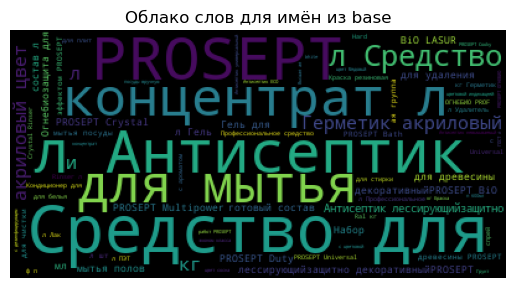

In [23]:
# Распаковка вложенных списков в один
extend_list_base = []
for sublist in name_list_base:
    extend_list_base.extend(sublist)
# Объединение всех токенов в одну строку
name_str_base = " ".join(extend_list_base)
# Построение графика "WordCloud"
wordcloud_base = WordCloud(background_color='black', random_state=RANDOM_STATE).generate(name_str_base)
plt.imshow(wordcloud_base)
plt.axis('off')
plt.title('Облако слов для имён из base')
plt.show()

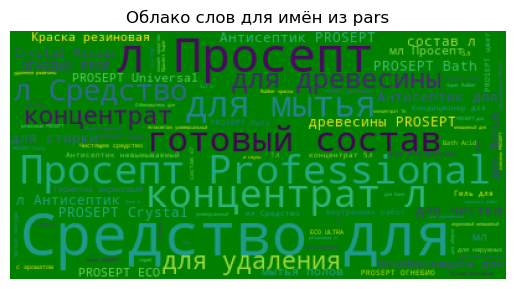

In [24]:
# Распаковка вложенных списков в один
extend_list_pars = []
for sublist in name_list_pars:
    extend_list_pars.extend(sublist)
# Объединение всех токенов в одну строку
name_str_pars = " ".join(extend_list_pars)
# Построение графика "WordCloud"
wordcloud_pars = WordCloud(background_color='green', random_state=RANDOM_STATE).generate(name_str_pars)
plt.imshow(wordcloud_pars)
plt.axis('off')
plt.title('Облако слов для имён из pars')
plt.show()

**Замечание:**  
В обеих таблицах, очень распространены слова: `Просепт`, `PROSEPT`, и т.п. Это название производителя. Известно что парсер заказчика настроен искать только товары собственного производства. Поэтому эти названия в векторном представлении, могут негативно повлиять на предсказывания модели.    
Возможно, лучше удалить эти слова.

## Предобработка данных и ранжирование объектов.

### Создадим таблицу для проверки работы моделей.

In [25]:
# Объединение тоблиц
parsing_match = parsing_clear.merge(match, how='left', left_on='product_key', right_on='key')
parsing_match = parsing_match.merge(base[['id', 'name_1c']], how='left', left_on='product_id', right_on='id')
# Удаление строк с пропусками
parsing_match = parsing_match[parsing_match['product_id'].notna()]
parsing_match = parsing_match[parsing_match['name_1c'].notna()]
parsing_match.head(2)

,id_x,product_key,price,product_url,product_name,date,dealer_id_x,length,id_y,key,dealer_id_y,product_id,id,name_1c
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_pros...,Средство универсальное Prosept Universal Spray...,2023-07-11,2,6,1.0,546227,2.0,12.0,12.0,Универсальное чистящее средство PROSEPT Univer...
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multip...,"Концентрат Prosept Multipower для мытья полов,...",2023-07-11,2,8,4.0,546408,2.0,38.0,38.0,Средство для мытья полов PROSEPT Multipower ci...


### Обработаем тексты.

In [26]:
# Приведение слов к нижнему регистру
parsing_match['name_1c'] = parsing_match['name_1c'].str.lower()
parsing_match['product_name'] = parsing_match['product_name'].str.lower()
parsing_match['product_id'] = parsing_match['product_id'].astype(int)
parsing_match = parsing_match.reset_index()
parsing_match

,index,id_x,product_key,price,product_url,product_name,date,dealer_id_x,length,id_y,key,dealer_id_y,product_id,id,name_1c
0,0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_pros...,средство универсальное prosept universal spray...,2023-07-11,2,6,1.0,546227,2.0,12,12.0,универсальное чистящее средство prosept univer...
1,1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multip...,"концентрат prosept multipower для мытья полов,...",2023-07-11,2,8,4.0,546408,2.0,38,38.0,средство для мытья полов prosept multipower ci...
2,2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyus...,средство для чистки люстр prosept universal an...,2023-07-11,2,9,6.0,546234,2.0,18,18.0,несмываемое средство для очистки люстр prosept...
3,3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosep...,"удалитель ржавчины prosept rust remover 0,5л 0...",2023-07-11,2,9,5.0,651258,2.0,403,403.0,"удалитель ржавчины prosept rust remover, 0.5 л."
4,4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_b...,средство моющее для бани и сауны prosept multi...,2023-07-11,2,10,7.0,546355,2.0,39,39.0,моющее средство для бани и сауны prosept multi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,1923,18033,1092966,1422.0,https://www.sima-land.ru/1348772,антисептик для внутренних работ prosept interi...,2023-07-28,13,8,1164.0,1092966,13.0,258,258.0,антисептик для внутренних работ prosept interi...
1642,1925,18536,44231991,1349.0,https://www.wildberries.ru/catalog/44231991/de...,жидкое моющее средство для стирки crystal конц...,2023-07-28,1,9,1683.0,44231991,1.0,150,150.0,гель для стирки с ароматом белых цветов prosep...
1643,1935,19352,1462340,199.0,NaN,средство для мытья плитки керамогранита prosep...,2023-07-31,7,10,509.0,1462340,7.0,40,40.0,средство для мытья плитки и керамогранита pros...
1644,1939,20246,45316302,515.0,https://www.wildberries.ru/catalog/45316302/de...,"антисептик невымываемый для конструкций, 5л",2023-07-31,1,5,1723.0,45316302,1.0,271,271.0,невымываемый антисептик для ответственных конс...


**Замечание:**  
Получилось 1646 строк. Дубликатов нет. 

### Создадим переменные и напишем функции для удобства.

In [27]:
# Загрузка данных из базы данных
database_data = parsing_match[['name_1c', 'product_id']].drop_duplicates()

# Загрузка спаршенных данных
parsed_data = parsing_match[['product_name', 'product_id']]

In [28]:
# Функция пересчёта индексов из KNN в соответствии "product_id" из базы
def true_indices(knn_indices=None, base=database_data, col='product_id'):
    '''
    knn_indices - индексы получаемые из KNN
    base - базовая таблица
    col - колонка в базе по которой происходит сравнение результатов
    '''
    indices_new=[]
    for ind in knn_indices:
        ind_new = []
        for n in ind:
            ind_new.append(base.iloc[n, base.columns.get_loc(col)])
        indices_new.append(ind_new)     
    return indices_new

In [29]:
# Функция рассчёта расстояний между векторами c помощью KNN
def ranking(model, base_vectors, pars_vectors, base, col):
    '''
    model - модель KNN 
    base_vectors - векторы полученные из текстов из base    
    pars_vectors - векторы полученные из текстов из pars
    base - базовая таблица
    col - колонка в базе по которой происходит сравнение результатов
    '''
    # Обучение (модель запоминает значения векторов из базы)
    model.fit(base_vectors)

    # Рассчёт расстояний для данных из pars от каждого из base
    # Получение информации в отсортированном виде (от ближайшего вектора к дальнему)
    distances, indices = model.kneighbors(pars_vectors)

    # Пересчёт индексов в "product_id" с помощью функции "true_indices"
    indices_new = true_indices(knn_indices=indices, base=base, col=col)
        
    # Вывод результатов
    result = pd.DataFrame(indices_new)
    result['match'] = parsing_match[col]
    
    return result 

In [30]:
# Функция проверки соответсвия значений: в первой колонке, в первых пяти колонках, в десяти первых колонках
def precision_at(df, ret_df=False):
    '''
    df - таблица с полученными результатами ранжирования
    ret_df - условия вывода таблицы с ответами (True/False) по условию совпадения значений в столбцах
    '''
    # Проверка совпадения на первом месте
    df['At_1'] = (df['match'] == df[0])

    # Проверка совпадения в первых пяти позициях
    df['At_5'] = ((df['match'] == df[0]) | 
                      (df['match'] == df[1]) |
                      (df['match'] == df[2]) |
                      (df['match'] == df[3]) |
                      (df['match'] == df[4]) )

    # Проверка совпадения в первых пяти позициях
    df['At_10'] = ((df['match'] == df[0]) | 
                       (df['match'] == df[1]) |
                       (df['match'] == df[2]) |
                       (df['match'] == df[3]) |
                       (df['match'] == df[4]) |
                       (df['match'] == df[5]) |
                       (df['match'] == df[6]) |
                       (df['match'] == df[7]) |
                       (df['match'] == df[8]) |
                       (df['match'] == df[9]) )
    
    # Построение таблицы с результатами рассчётов
    data = {'rank_at1': df['At_1'].value_counts(normalize=True)[True],
            'rank_at5': df['At_5'].value_counts(normalize=True)[True],
            'rank_at10': df['At_10'].value_counts(normalize=True)[True]}
    precision_df = pd.DataFrame(data, index=['Точность']).T
    
    if ret_df == True:
        return display(df, precision_df)
    return precision_df

### Исследуем метод  `ngram`.

In [31]:
# Инициализация CountVectorizer
count_vect = CountVectorizer(ngram_range=(3, 3))

# Обучение и получение n_gramm для base
n_gramm_base = count_vect.fit_transform(database_data['name_1c']) 
print("Размер base:", n_gramm_base.shape)

# Получение n_gramm для pars
n_gramm_pars = count_vect.transform(parsed_data['product_name']) 
print("Размер pars:", n_gramm_pars.shape)

Размер base: (416, 1158)
Размер pars: (1646, 1158)


In [32]:
# Инициализация модели сравнения расстояния между векторами
model_euclidean = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')

In [33]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_n_gramm = ranking(model_euclidean, n_gramm_base, n_gramm_pars, database_data, col='product_id')
result_n_gramm.sample(5)

,0,1,2,3,4,5,6,7,8,9,match
35,73,281,70,210,279,163,209,327,218,219,72
1454,302,303,306,308,307,295,296,298,279,163,313
594,48,47,46,163,210,279,281,209,325,380,46
1563,411,210,281,279,163,209,380,325,381,330,409
921,290,210,281,163,209,279,378,380,327,219,291


In [34]:
# Рассчёт точности предсказаний
precision_at(result_n_gramm, ret_df=False)

,Точность
rank_at1,0.161604
rank_at5,0.292831
rank_at10,0.337181


### Tf-idf Vectorizer

In [35]:
# Инициализация векторайзера
vectorizer = TfidfVectorizer()
# Обучение и получение Tfidf для base
database_vectors_tfidf = vectorizer.fit_transform(database_data['name_1c'])
print("Размер base:", database_vectors_tfidf.shape)
# Получение Tfidf для pars
pars_vectors_tfidf = vectorizer.transform(parsed_data['product_name'])
print("Размер pars:", pars_vectors_tfidf.shape)

Размер base: (416, 543)
Размер pars: (1646, 543)


In [36]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_tfidf = ranking(model_euclidean, database_vectors_tfidf, pars_vectors_tfidf, database_data, col='product_id')
result_tfidf.sample(5)

,0,1,2,3,4,5,6,7,8,9,match
1426,420,418,419,432,423,429,426,431,430,427,420
1036,414,415,416,256,409,417,412,410,413,411,414
470,163,162,27,407,402,325,326,306,412,260,162
342,13,12,14,130,168,15,170,196,197,195,14
962,275,250,249,276,277,251,278,271,272,273,275


In [37]:
# Рассчёт точности предсказаний
precision_at(result_tfidf, ret_df=False)

,Точность
rank_at1,0.473876
rank_at5,0.849939
rank_at10,0.920413


### Эмбединги

#### SentenceTransformer

In [38]:
# Загрузка предобученной модели для получения эмбеддингов
# model = SentenceTransformer('distiluse-base-multilingual-cased')
model = SentenceTransformer('cointegrated/rubert-tiny2')

Some weights of the model checkpoint at C:\Users\Aleksei/.cache\torch\sentence_transformers\cointegrated_rubert-tiny2\ were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
database_vectors_emb = []
# Получение эмбедингов
for name  in notebook.tqdm(database_data['name_1c']):
    text_embedding = model.encode(name, convert_to_tensor=False)  
    database_vectors_emb.append(text_embedding)
# Вывод размеров эмбедингов
print(f'Размер base: {len(database_vectors_emb), len(database_vectors_emb[0])}')

  0%|          | 0/416 [00:00<?, ?it/s]

Размер base: (416, 312)


In [40]:
pars_vectors_emb = []
# Получение эмбедингов
for name in notebook.tqdm(parsed_data['product_name']):
    text_embedding = model.encode(name, convert_to_tensor=False)
    pars_vectors_emb.append(text_embedding)
# Вывод размеров эмбедингов
print(f'Размер pars: {len(pars_vectors_emb), len(pars_vectors_emb[0])}')

  0%|          | 0/1646 [00:00<?, ?it/s]

Размер pars: (1646, 312)


In [41]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_emb = ranking(model_euclidean, database_vectors_emb, pars_vectors_emb, database_data, col='product_id')
result_emb.sample(5)

,0,1,2,3,4,5,6,7,8,9,match
268,133,170,107,34,33,32,157,23,195,159,133
543,146,138,144,140,148,80,145,142,399,239,146
1086,226,370,366,225,224,374,155,463,227,384,224
570,38,26,28,22,30,24,27,29,23,212,38
39,263,287,43,321,286,39,42,44,206,15,263


In [42]:
# Рассчёт точности предсказаний
precision_at(result_emb, ret_df=False)

,Точность
rank_at1,0.605103
rank_at5,0.842041
rank_at10,0.900365


#### BERT

##### Нормализация

In [43]:
# Функция нормализации эмбедингов
def normalize_embeddings(embeddings):
    norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
    normalized_embeddings = embeddings / norms
    return normalized_embeddings

In [44]:
# Загрузка предобученной модели BERT и токенизатора
# model_name = 'bert-base-uncased'
# model_name = 'DeepPavlov/rubert-base-cased'
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


database_vectors_emb_bert = []
# Токенизация текста
for name in notebook.tqdm(database_data['name_1c']):
    tokens = tokenizer.encode(name, add_special_tokens=True, return_tensors='pt')

    # Получение эмбедингов
    with torch.no_grad():
        outputs = model(tokens)
        # Усреднение эмбедингов всех токенов
        embeddings = outputs.last_hidden_state.mean(dim=1) 
        # Нормализация эмбедингов
        embeddings = normalize_embeddings(embeddings)
        
    database_vectors_emb_bert.append(embeddings[0,:].numpy())
    
# Вывод размеров эмбедингов
print(f'Размер base: {len(database_vectors_emb_bert), len(database_vectors_emb_bert[0])}')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/416 [00:00<?, ?it/s]

Размер base: (416, 768)


In [45]:
pars_vectors_emb_bert = []
# Токенизация текста
for name in notebook.tqdm(parsed_data['product_name']):
    tokens = tokenizer.encode(name, add_special_tokens=True, return_tensors='pt')

    # Получение эмбедингов
    with torch.no_grad():
        outputs = model(tokens)
        # Усреднение эмбедингов всех токенов
        embeddings = outputs.last_hidden_state.mean(dim=1)
        # Нормализация эмбедингов
        embeddings = normalize_embeddings(embeddings)
    pars_vectors_emb_bert.append(embeddings[0,:].numpy())
    
# Вывод размеров эмбедингов
print(f'Размер base: {len(pars_vectors_emb_bert), len(pars_vectors_emb_bert[0])}')

  0%|          | 0/1646 [00:00<?, ?it/s]

Размер base: (1646, 768)


In [46]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_emb_bert = ranking(model_euclidean, database_vectors_emb_bert, pars_vectors_emb_bert, database_data, col='product_id')
result_emb_bert.sample(5)

,0,1,2,3,4,5,6,7,8,9,match
1326,202,200,203,201,161,160,205,204,41,52,200
1238,291,290,415,414,184,409,85,410,205,268,291
563,60,61,258,257,254,253,255,46,59,48,61
445,352,354,338,349,353,355,350,351,356,331,18
1063,220,385,383,384,292,294,293,464,234,237,385


In [47]:
# Рассчёт точности предсказаний
precision_at(result_emb_bert, ret_df=False)

,Точность
rank_at1,0.412515
rank_at5,0.691981
rank_at10,0.767315


##### Стандартизация

In [48]:
# Создание объекта стандартизации
scaler = StandardScaler()

# Применение стандартизации к эмбеддингам
database_vectors_emb_bert_stand = scaler.fit_transform(database_vectors_emb_bert)
pars_vectors_emb_bert_stand = scaler.fit_transform(pars_vectors_emb_bert)

In [49]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_emb_bert_stand = ranking(model_euclidean,
                                database_vectors_emb_bert_stand,
                                pars_vectors_emb_bert_stand,
                                database_data,
                                col='product_id')
result_emb_bert_stand.sample(5)

,0,1,2,3,4,5,6,7,8,9,match
647,52,53,54,55,172,204,87,107,109,89,55
1619,293,292,294,380,378,381,382,379,377,165,386
469,60,61,40,46,41,48,47,19,59,63,60
737,97,87,101,89,100,102,98,84,99,202,97
757,259,260,261,294,292,293,253,255,254,257,282


In [50]:
# Рассчёт точности предсказаний
precision_at(result_emb_bert_stand, ret_df=False)

,Точность
rank_at1,0.434386
rank_at5,0.722357
rank_at10,0.794046


## Вывод.

На данный момент лучшего качества удалось добиться с помощью модели получения эмбедингов model `SentenceTransformer('cointegrated/rubert-tiny2')`.

In [51]:
# Рассчёт точности предсказаний
precision_at(result_emb, ret_df=False)

,Точность
rank_at1,0.605103
rank_at5,0.842041
rank_at10,0.900365


Предобученная "тяжёлая" модель Bert неожиданно показала худший результат.

**Идеи:**
- поскать другие предобученные модели
- выполнить качественную предобработку текстов
- использовать дополнительную модель поверх KNN для получения более высокого качества предсказаний.

## Продолжение работы (исследование и эксперименты).

### Измерить метрику.

###  Обучить Bert для получения эмбедингов.

###  Обучить дополнительную модель (регрессии) на основе 30 - 100 наиболее близких текстов (после KNN).